# Initial CLV Model

Experiment with a variety of factors and datasets to predict Customer Lifetime Value for Koenig using just their data. Objective is to atempt to measure a 5 year CLV that encompasses wholesale as well as service. Future models should include parts but that isn't available right now. 

From a data perspective we start by looking at the past 5 years as features and the target variable is the future 5 years. To start, we'll have 12 years of data from 2011 through 2023. So first dataset would be 2015 looking back 5 years (2015 inclusive) then predicting on data from 2016 to 2021. We can then repeat this with start years of 2016 and 2017 to help us validate. No account will be present in both train and test so we'll make sure to have the random train/test split handle this.

In [1]:
%load_ext dotenv
%dotenv
%load_ext autoreload
%autoreload 2

In [350]:
import json

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import xgboost as xgb

from src.transformation.translate import (
    translate_csv_to_common_model,
    translate_koenig_account_columns,
    translate_keonig_customer_equipment,
    translate_koenig_stock_unit,
    translate_koenig_purchase_orders,
    translate_koenig_service_requests,
    translate_koenig_user,
    translate_koenig_store,
)

## Pulling Data & Creating Dataset

In [330]:
account_df = translate_csv_to_common_model(
    "data/dealers/koenig/account.csv",
    "koenig",
    "./src/transformation/semantic_layer.json",
    "account",
)
stock_unit_df = translate_csv_to_common_model(
    "data/dealers/koenig/dealer-stock-unit.csv",
    "koenig",
    "./src/transformation/semantic_layer.json",
    "dealer_stock_unit",
)
sales_history_df = translate_csv_to_common_model(
    "data/dealers/koenig/sales-history.csv",
    "koenig",
    "./src/transformation/semantic_layer.json",
    "sales_history",
)
account_df = translate_koenig_account_columns(account_df)
stock_unit_df = translate_koenig_stock_unit(stock_unit_df)

In [332]:
account_df = account_df[
    [
        "account_id",
        "account_number",
        "account_owner_id",
        "customer_segment",
        "type_of_equipment",
        "customer_loyalty",
        "customer_business_class",
        "engagement_level",
    ]
]
stock_unit_df = stock_unit_df[
    [
        "dealer_stock_unit_id",
        "dealer_stock_number",
        "dsu_account_id",
        "dsu_description",
        "dsu_status",
        "dsu_group",
        "dsu_model_year",
        "dsu_make",
        "dsu_model",
        "dsu_serial_number",
        "dsu_new_used",
        "dsu_sub_group",
        "dsu_hours_or_units",
        "dsu_store",
        "dsu_user_traded_by",
        "dsu_sale_price",
        "dsu_sales_date",
        "dsu_invoice_number",
        "dsu_invoice_amount",
        "dsu_sold_by",
    ]
]

In [318]:
account_df.filter(pl.col("account_id") == "0015f000005XXEQAA4")

account_id,account_number,account_owner_id,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,engagement_level
str,str,str,str,str,str,str,str


### Investigate Difference Between History & Stock Units

In [333]:
stock_unit_yearly_df = stock_unit_df.filter(
    ~pl.col("dsu_invoice_number").is_in(["NOTAVA", "EQPADD", "N/A"])
).filter(pl.col("dsu_sales_date").dt.year() >= 2011)
stock_unit_yearly_df = stock_unit_yearly_df.with_columns(
    pl.col("dsu_sales_date").dt.year().alias("dsu_sale_year"),
    pl.when(
        (pl.col("dsu_sales_date").dt.month() >= 1)
        & (pl.col("dsu_sales_date").dt.month() <= 10)
    )
    .then(pl.col("dsu_sales_date").dt.year())
    .otherwise(pl.col("dsu_sales_date").dt.year() + 1)
    .alias("dsu_fiscal_year"),
)
stock_unit_yearly_df = stock_unit_yearly_df.group_by(
    ["dsu_account_id", "dsu_fiscal_year"]
).agg(
    pl.col("dsu_invoice_amount").sum().alias("dsu_sale_price"),
    pl.col("dealer_stock_unit_id").count().alias("dsu_count"),
)
stock_unit_yearly_df = stock_unit_yearly_df.with_columns(
    pl.col("dsu_account_id"),
    pl.col("dsu_fiscal_year").cast(pl.Int64).alias("dsu_fiscal_year"),
    # create a fiscal year column. If sale month between 1 and 10 (inclusive), then fiscal year is the same as sale year. Otherwise, fiscal year is sale year + 1
    pl.col("dsu_sale_price").cast(pl.Float64).alias("dsu_sale_price"),
    pl.col("dsu_count").cast(pl.Int64).alias("dsu_count"),
)
stock_unit_yearly_df.head()

dsu_account_id,dsu_fiscal_year,dsu_sale_price,dsu_count
str,i64,f64,i64
"""0015f000005XxxyAAC""",2012,40041.56,1
"""0015f000005XLLHAA4""",2014,2999.0,1
"""0015f00000P66lAAAR""",2022,5439.0,1
"""0015f000005XBjKAAW""",2021,49995.0,1
"""0015f000005Xj40AAC""",2012,1939.0,1


In [334]:
combined_df = sales_history_df.join(
    account_df[["account_id"]],
    left_on="sales_history_account_id",
    right_on="account_id",
    how="inner",
)

combined_df = combined_df.join(
    stock_unit_yearly_df,
    left_on=["sales_history_account_id", "sales_history_year"],
    right_on=["dsu_account_id", "dsu_fiscal_year"],
    how="left",
)

combined_df.head()

sales_history_id,sales_history_account_id,sales_history_year,sales_history_parts_sales,sales_history_service_sales,sales_history_rental_sales,sales_history_wholegood_sales,sales_history_total_sales,dsu_sale_price,dsu_count
str,str,i64,i64,i64,i64,i64,i64,f64,i64
"""a005f000002eGBwAAM""","""0015f000005Xy1eAAC""",2021,7176,2087,0,0,9688,null,null
"""a005f000002eGBzAAM""","""0015f000005XyD1AAK""",2021,9625,4052,0,0,13929,null,null
"""a005f000002eGC0AAM""","""0015f000005X32sAAC""",2021,1463801,2341091,0,0,4499216,null,null
"""a005f000002eGC1AAM""","""0015f000005XwRCAA0""",2021,386,0,0,0,386,null,null
"""a005f000002eGC2AAM""","""0015f000005Xw7KAAS""",2021,20161,14055,0,0,34746,null,null


In [337]:
stock_unit_df.filter(pl.col("dsu_account_id") == "0015f000005Xz6JAAS").filter(
    pl.col("dsu_sales_date").dt.year() == 2021
).sort("dsu_sales_date", descending=False)

dealer_stock_unit_id,dealer_stock_number,dsu_account_id,dsu_description,dsu_status,dsu_group,dsu_model_year,dsu_make,dsu_model,dsu_serial_number,dsu_new_used,dsu_sub_group,dsu_hours_or_units,dsu_store,dsu_user_traded_by,dsu_sale_price,dsu_sales_date,dsu_invoice_number,dsu_invoice_amount,dsu_sold_by
str,str,str,str,str,str,i64,str,str,str,str,str,f64,str,str,f64,date,str,f64,str
"""a065f000001RU3DAAW""","""194050""","""0015f000005Xz6JAAS""","""AgLogic Subscription & Activat…","""Invoiced""","""AMS COMPONENTS""",2021,"""JD""","""AMS""","""NO TAG""","""N""","""Agricultural Equipment""",0.0,"""a0S5f000000xeIOEAY""",null,1549.0,2021-03-20,"""078618""",350.0,"""0055f000002kaqKAAQ"""
"""a065f000001RU3EAAW""","""194051""","""0015f000005Xz6JAAS""","""AgLogic Subscription & Activat…","""Invoiced""","""AMS COMPONENTS""",2021,"""JD""","""AMS""","""NO TAG""","""N""","""Agricultural Equipment""",0.0,"""a0S5f000000xeIOEAY""",null,1549.0,2021-03-20,"""078619""",350.0,"""0055f000002kaqKAAQ"""
"""a065f000001RU3FAAW""","""194052""","""0015f000005Xz6JAAS""","""AgLogic Subscription & Activat…","""Invoiced""","""AMS COMPONENTS""",2021,"""JD""","""AMS""","""NO TAG""","""N""","""Agricultural Equipment""",0.0,"""a0S5f000000xeIOEAY""",null,1549.0,2021-03-20,"""078620""",350.0,"""0055f000002kaqKAAQ"""
"""a065f000001RU3GAAW""","""194053""","""0015f000005Xz6JAAS""","""AgLogic Subscription & Activat…","""Invoiced""","""AMS COMPONENTS""",2021,"""JD""","""AMS""","""NO TAG""","""N""","""Agricultural Equipment""",0.0,"""a0S5f000000xeIOEAY""",null,1549.0,2021-03-20,"""078621""",350.0,"""0055f000002kaqKAAQ"""
"""a065f000001RU3HAAW""","""194054""","""0015f000005Xz6JAAS""","""AgLogic Subscription & Activat…","""Invoiced""","""AMS COMPONENTS""",2021,"""JD""","""AMS""","""NO TAG""","""N""","""Agricultural Equipment""",0.0,"""a0S5f000000xeIOEAY""",null,1549.0,2021-03-20,"""078622""",350.0,"""0055f000002kaqKAAQ"""
"""a065f000001RU3IAAW""","""194055""","""0015f000005Xz6JAAS""","""AgLogic Subscription & Activat…","""Invoiced""","""AMS COMPONENTS""",2021,"""JD""","""AMS""","""NO TAG""","""N""","""Agricultural Equipment""",0.0,"""a0S5f000000xeIOEAY""",null,1549.0,2021-03-20,"""078623""",1549.0,"""0055f000002kaqKAAQ"""
"""a065f000001RRafAAG""","""0109117""","""0015f000005Xz6JAAS""","""R4045 Self-Propelled Sprayer (…","""Invoiced""","""SPRAYERS""",2019,"""JD""","""R4045""","""1N04045RHJ0196004""","""N""","""Agricultural Equipment""",1920.0,"""a0S5f000000xeI2EAI""",null,491387.72,2021-07-28,"""048728""",630268.72,"""0055f000002kaqYAAQ"""


In [336]:
combined_df.filter(pl.col("sales_history_wholegood_sales") != 0).filter((pl.col("sales_history_wholegood_sales") - pl.col("dsu_sale_price")).abs() / pl.col("sales_history_wholegood_sales") > 0.85)

sales_history_id,sales_history_account_id,sales_history_year,sales_history_parts_sales,sales_history_service_sales,sales_history_rental_sales,sales_history_wholegood_sales,sales_history_total_sales,dsu_sale_price,dsu_count
str,str,i64,i64,i64,i64,i64,i64,f64,i64
"""a005f000002eGKYAA2""","""0015f000005XzOUAA0""",2021,9114,8918,0,500,19337,1102.58,1
"""a005f000002eGQEAA2""","""0015f000005XX6fAAG""",2021,5364,0,0,700,6144,25470.0,2
"""a005f000002eGRbAAM""","""0015f000005XJ0pAAG""",2021,31162,6760,0,300,40855,600.0,1
"""a005f000002eGaRAAU""","""0015f000005XrmmAAC""",2021,25333,1991,0,1000,29556,2205.16,2
"""a005f000002eGytAAE""","""0015f000005Xz6JAAS""",2021,22052,11891,0,3299,40639,633567.72,7
…,…,…,…,…,…,…,…,…,…
"""a005f000009ugtXAAQ""","""0015f000005XfLUAA0""",2023,21347,849,0,125626,148377,8292.0,5
"""a005f000009wZqRAAU""","""0015f000005XX0BAAW""",2023,587,0,0,81718,82305,3903.63,1
"""a005f000009wax1AAA""","""0015f000005Xx1yAAC""",2023,618,0,0,28949,29567,1151.99,1


### Create Most Frequent Group

For each account and sale year, identify the most common group both from units and value. To avoid leakage we look at the year and years prior to identify most common rather than look at this over all time. This is why after each year you see the common group/highest value change over each year.

In [167]:
stock_unit_df = stock_unit_df.filter(
    ~pl.col("dsu_invoice_number").is_in(["NOTAVA", "EQPADD", "N/A"])
).filter(pl.col("dsu_sales_date").dt.year() >= 2011)
# create new column for sale year
stock_unit_df = stock_unit_df.with_columns(
    pl.col("dsu_sales_date").dt.year().alias("dsu_sale_year")
)
group_year_df = stock_unit_df[["dsu_group", "dsu_sale_year"]].unique()
group_year_df.head()

dsu_group,dsu_sale_year
str,i32
"""ROW CROP TRACTOR""",2021
"""BAGGERS/COLLECTION""",2020
"""FORAGE HARVESTING EQ""",2014
"""TILLERS""",2018
"""PRIMARY TILLAGE""",2016


In [213]:
unique_accounts = stock_unit_df.select("dsu_account_id").unique()
unique_years = stock_unit_df.select("dsu_sale_year").unique()
unique_groups = stock_unit_df.select("dsu_group").unique()

all_combinations = unique_accounts.join(unique_years, how="cross").join(
    unique_groups, how="cross"
)
stock_unit_group_df = (
    stock_unit_df.filter(pl.col("dsu_group") != "AMS COMPONENTS")
    .sort(
        ["dsu_account_id", "dsu_sale_year"], descending=False
    )  # Ensure the data is sorted
    .group_by(["dsu_account_id", "dsu_sale_year", "dsu_group"])
    .agg(
        pl.col("dsu_group").count().alias("count"),
        pl.col("dsu_sale_price").sum().alias("total_sales"),
    )
).sort(
    [
        "dsu_account_id",
        "dsu_sale_year",
    ],
    descending=False,
)

stock_unit_group_df = all_combinations.join(
    stock_unit_group_df,
    on=["dsu_account_id", "dsu_sale_year", "dsu_group"],
    how="left",
).fill_null(0)
stock_unit_group_df.head()

dsu_account_id,dsu_sale_year,dsu_group,count,total_sales
str,i32,str,u32,f64
"""0015f000005XazrAAC""",2013,"""DRAPER PLATFORMS""",0,0.0
"""0015f000005XazrAAC""",2013,"""SKID & TRACK LOADERS""",0,0.0
"""0015f000005XazrAAC""",2013,"""APPLICATOR""",0,0.0
"""0015f000005XazrAAC""",2013,"""VERTICAL TILLAGE""",0,0.0
"""0015f000005XazrAAC""",2013,"""COMPACT TRACTOR""",0,0.0


In [214]:
stock_unit_group_df = stock_unit_group_df.sort(["dsu_account_id", "dsu_sale_year"], descending=[False, False]).select(
    pl.col("dsu_account_id", "dsu_sale_year", "dsu_group"),
    pl.col("count")
    .cum_sum()
    .over("dsu_account_id", "dsu_group")
    .alias("cumulative_count"),
    pl.col("total_sales")
    .cum_sum()
    .over("dsu_account_id", "dsu_group")
    .alias("cumulative_sales"),
)
stock_unit_group_df = stock_unit_group_df.sort(
    ["dsu_account_id", "dsu_sale_year", "cumulative_count", "cumulative_sales"],
    descending=[False, False, True, True],
)
stock_unit_frequent_df = stock_unit_group_df.group_by(["dsu_account_id", "dsu_sale_year"]).agg(
    pl.col("dsu_group").first().alias("most_common_group"),
)
stock_unit_group_df = stock_unit_group_df.sort(
    ["dsu_account_id", "dsu_sale_year", "cumulative_sales", "cumulative_count"],
    descending=[False, False, True, True],
)

stock_unit_value_df = stock_unit_group_df.group_by(["dsu_account_id", "dsu_sale_year"]).agg(
    pl.col("dsu_group").first().alias("largest_sales_group"),
)
stock_unit_group_df = stock_unit_frequent_df.join(
    stock_unit_value_df, on=["dsu_account_id", "dsu_sale_year"], how="inner"
)
stock_unit_group_df = stock_unit_group_df.with_columns(
    pl.col("dsu_account_id"),
    pl.col("dsu_sale_year").cast(pl.Int64),
    pl.col("most_common_group"),
    pl.col("largest_sales_group"),
)
stock_unit_group_df.head()

dsu_account_id,dsu_sale_year,most_common_group,largest_sales_group
str,i64,str,str
"""0015f000005XyFPAA0""",2011,"""MOWER""","""MOWER"""
"""0015f000005X8S4AAK""",2015,"""RIDERS LAWN TRACTORS""","""RIDERS LAWN TRACTORS"""
"""0015f000005XapFAAS""",2015,"""OTHER AG EQUIPMENT""","""OTHER AG EQUIPMENT"""
"""0015f000005XvhnAAC""",2019,"""UTILITY VEHICLES""","""UTILITY VEHICLES"""
"""0015f000005Xpa9AAC""",2016,"""AMS COMPONENTS""","""AMS COMPONENTS"""


In [207]:
stock_unit_group_df.filter(pl.col("most_common_group") != pl.col("largest_sales_group")).head()

dsu_account_id,dsu_sale_year,most_common_group,largest_sales_group
str,i32,str,str
"""0015f000005XvptAAC""",2021,"""AUGER PLATFORMS""","""COMBINES"""
"""0015f000005XYHLAA4""",2021,"""OTHER LANDSCAPE EQ""","""COMPACT TRACTOR"""
"""0015f000005X2uJAAS""",2022,"""UTILITY TRACTOR""","""4WD TRACTOR"""
"""0015f000005X6dwAAC""",2022,"""UTILITY TRACTOR""","""COMPACT TRACTOR"""
"""0015f000005XczuAAC""",2016,"""OTHER LANDSCAPE EQ""","""UTILITY TRACTOR"""


In [198]:
stock_unit_group_df.filter(pl.col("dsu_account_id") == "0015f000005X2stAAC").filter(
    pl.col("cumulative_count") > 0
).filter(pl.col("dsu_group").is_in(["ROW CROP TRACTOR"])).sort("dsu_sale_year")

dsu_account_id,dsu_sale_year,dsu_group,cumulative_count,cumulative_sales
str,i32,str,u32,f64
"""0015f000005X2stAAC""",2020,"""ROW CROP TRACTOR""",1,274871.0
"""0015f000005X2stAAC""",2021,"""ROW CROP TRACTOR""",2,554771.0
"""0015f000005X2stAAC""",2022,"""ROW CROP TRACTOR""",3,771562.0
"""0015f000005X2stAAC""",2023,"""ROW CROP TRACTOR""",4,1.083462e6
"""0015f000005X2stAAC""",2024,"""ROW CROP TRACTOR""",4,1.083462e6


### Clean Account Data

In [208]:
account_df.head()

account_id,account_number,account_owner_id,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,engagement_level
str,str,str,str,str,str,str,str
"""0015f000002Z29jAAC""",null,"""0055f000002FVJhAAO""",null,null,null,null,"""Not Engaged"""
"""0015f0000030vGsAAI""",null,"""0055f000002kaqfAAA""",null,null,null,null,"""Not Engaged"""
"""0015f000005X2stAAC""","""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital"""
"""0015f000005X2t2AAC""","""BEARH001""","""0055f000002kaq0AAA""",null,null,null,"""D - Transaction Account""","""Not Engaged"""
"""0015f000005X2t5AAC""","""BEISE003""","""0055f000009ChOUAA0""",null,null,"""Other Competitor""","""A - Strategic Account""","""R12 Digitally Engaged"""


In [210]:
account_df = account_df.with_columns(
    pl.col("account_id"),
    pl.col("account_number"),
    pl.col("account_owner_id"),
    pl.col("customer_segment").fill_null("Unknown"),
    pl.col("type_of_equipment").fill_null("Unknown"),
    pl.col("customer_loyalty").fill_null("Unknown"),
    pl.col("customer_business_class").fill_null("Unknown"),
    pl.col("engagement_level").fill_null("Unknown"),
)
account_df.head()

account_id,account_number,account_owner_id,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,engagement_level
str,str,str,str,str,str,str,str
"""0015f000002Z29jAAC""",null,"""0055f000002FVJhAAO""","""Unknown""","""Unknown""","""Unknown""","""Unknown""","""Not Engaged"""
"""0015f0000030vGsAAI""",null,"""0055f000002kaqfAAA""","""Unknown""","""Unknown""","""Unknown""","""Unknown""","""Not Engaged"""
"""0015f000005X2stAAC""","""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital"""
"""0015f000005X2t2AAC""","""BEARH001""","""0055f000002kaq0AAA""","""Unknown""","""Unknown""","""Unknown""","""D - Transaction Account""","""Not Engaged"""
"""0015f000005X2t5AAC""","""BEISE003""","""0055f000009ChOUAA0""","""Unknown""","""Unknown""","""Other Competitor""","""A - Strategic Account""","""R12 Digitally Engaged"""


### Combine Datasets
Put together everything

In [211]:
sales_history_df.head()

sales_history_id,sales_history_account_id,sales_history_year,sales_history_parts_sales,sales_history_service_sales,sales_history_rental_sales,sales_history_wholegood_sales,sales_history_total_sales
str,str,i64,i64,i64,i64,i64,i64
"""a005f000002eGBwAAM""","""0015f000005Xy1eAAC""",2021,7176,2087,0,0,9688
"""a005f000002eGBxAAM""","""0015f000005XnHEAA0""",2021,2813,357,0,0,3190
"""a005f000002eGByAAM""","""0015f000005X331AAC""",2021,188616,2328,0,0,192517
"""a005f000002eGBzAAM""","""0015f000005XyD1AAK""",2021,9625,4052,0,0,13929
"""a005f000002eGC0AAM""","""0015f000005X32sAAC""",2021,1463801,2341091,0,0,4499216


In [216]:
data_df = (
    sales_history_df.join(
        account_df,
        left_on="sales_history_account_id",
        right_on="account_id",
        how="inner",
    )
    .join(
        stock_unit_group_df,
        left_on=["sales_history_account_id", "sales_history_year"],
        right_on=["dsu_account_id", "dsu_sale_year"],
        how="inner",
    )
    .sort(
        ["sales_history_account_id", "sales_history_year"],
        descending=False,
    )
)
data_df.head()

sales_history_id,sales_history_account_id,sales_history_year,sales_history_parts_sales,sales_history_service_sales,sales_history_rental_sales,sales_history_wholegood_sales,sales_history_total_sales,account_number,account_owner_id,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,engagement_level,most_common_group,largest_sales_group
str,str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str
"""a005f000002fua6AAA""","""0015f000005X2stAAC""",2016,2,0,0,0,2,"""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital""","""GRAIN HAULING""","""DRILLS & AIR SEEDERS"""
"""a005f000002g54ZAAQ""","""0015f000005X2stAAC""",2017,293,0,0,0,293,"""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital""","""GRAIN HAULING""","""DRILLS & AIR SEEDERS"""
"""a005f000002ewIlAAI""","""0015f000005X2stAAC""",2018,3037,1712,0,0,7549,"""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital""","""GRAIN HAULING""","""DRILLS & AIR SEEDERS"""
"""a005f000002elyeAAA""","""0015f000005X2stAAC""",2019,776,0,0,0,818,"""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital""","""GRAIN HAULING""","""DRILLS & AIR SEEDERS"""
"""a005f000002eVXMAA2""","""0015f000005X2stAAC""",2020,6136,8063,0,297316,312365,"""BALDW010""","""0055f000002kaqvAAA""","""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""Land & Digital""","""GRAIN HAULING""","""ROW CROP TRACTOR"""


In [274]:
data_3_year_2018_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2018, 2017, 2016]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_year").max().alias("latest_year"),
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_3_year_2018_next_3_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2019, 2020, 2021]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_three_years_total_sales"),
    )
)
data_3_year_2018_df = data_3_year_2018_previous_df.join(data_3_year_2018_next_3_year_df, on="sales_history_account_id", how="inner")
data_3_year_2018_df.head()

sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_three_years_total_sales
str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,i64
"""0015f000005XRn1AAG""",2018,2637,2641,0,0,5278,"""Unknown""","""Unknown""","""Unknown""","""C - Relationship Account""","""ROTARY & BOOM MOWERS""","""ROTARY & BOOM MOWERS""",1611
"""0015f000005Xyh5AAC""",2018,55217,23754,-2500,816409,897580,"""Grain Hogs""","""New Only""","""Other Competitor""","""B - Key Account""","""COMBINES""","""COMBINES""",1300993
"""0015f000005XyjCAAS""",2018,19057,20625,0,5295,44977,"""Cash Grain""","""Used Only""","""In-Line Koenig""","""C - Relationship Account""","""COMBINES""","""COMBINES""",323835
"""0015f000005XxceAAC""",2018,15907,14011,0,0,29918,"""Cash Grain""","""Used Only""","""Rainbow Competitor""","""C - Relationship Account""","""SKID & TRACK LOADERS""","""PLANTERS""",13117
"""0015f000005XUqZAAW""",2018,6923,2075,0,6100,24809,"""Cash Grain""","""Used Only""","""In-Line Koenig""","""C - Relationship Account""","""COMMERCIAL ZERO & FM""","""COMMERCIAL ZERO & FM""",471


## Create a CLV model

Using the 3 year data_df try and predict the next three year totals. 

In [338]:
data_3_year_2018_pd_df = data_3_year_2018_df.to_pandas()
data_3_year_2018_pd_df = data_3_year_2018_pd_df.loc[
    (data_3_year_2018_pd_df["customer_business_class"] != "A - Turf Strategic Account")
    & (data_3_year_2018_pd_df["customer_segment"] != "Specialty Crop")
    & (data_3_year_2018_pd_df["most_common_group"] != "SPRAYERATT")
]
cont_vars = ['parts_sales', 'service_sales', 'rental_sales', 'sales_history_wholegood_sales']
cat_vars = ['customer_segment', 'type_of_equipment', 'customer_loyalty', 'most_common_group', 'largest_sales_group']

X = data_3_year_2018_pd_df[cont_vars + cat_vars]

y = data_3_year_2018_pd_df["next_three_years_total_sales"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_vars),  # Scale continuous variables
        (
            "cat",
            OneHotEncoder(drop="first"),
            cat_vars,
        ),  # One-hot encode categorical variables
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model",xgb.XGBRegressor(objective="reg:squarederror", random_state=69)),
    ]
)

In [339]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=69)

mse_scores = cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=kf)
mse_scores = -mse_scores

mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

In [340]:
print(f"Mean MSE: {mean_mse:.4f}")
print(f"Standard Deviation of MSE: {std_mse:.4f}")

Mean MSE: 112283778371.7480
Standard Deviation of MSE: 47862621224.9395


In [342]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['parts_sales',
                                                   'service_sales',
                                                   'rental_sales',
                                                   'sales_history_wholegood_sales']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['customer_segment',
                                                   'type_of_equipment',
                                                   'customer_loyalty',
                                                   'most_common_group',
                                                   'largest_sales_group'])])),
                ('model',
                 XGBRegressor(base_score=None, boo...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=69, ...))])

In [343]:
preds = pipeline.predict(X)
data_3_year_2018_with_preds_pd_df = data_3_year_2018_pd_df.copy()
data_3_year_2018_with_preds_pd_df["predicted_next_three_years_total_sales"] = preds
data_3_year_2018_with_preds_pd_df.head()

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_three_years_total_sales,predicted_next_three_years_total_sales
0,0015f000005XRn1AAG,2018,2637,2641,0,0,5278,Unknown,Unknown,Unknown,C - Relationship Account,ROTARY & BOOM MOWERS,ROTARY & BOOM MOWERS,1611,2.593905e+04
1,0015f000005Xyh5AAC,2018,55217,23754,-2500,816409,897580,Grain Hogs,New Only,Other Competitor,B - Key Account,COMBINES,COMBINES,1300993,1.250130e+06
2,0015f000005XyjCAAS,2018,19057,20625,0,5295,44977,Cash Grain,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,323835,2.859099e+05
3,0015f000005XxceAAC,2018,15907,14011,0,0,29918,Cash Grain,Used Only,Rainbow Competitor,C - Relationship Account,SKID & TRACK LOADERS,PLANTERS,13117,3.889541e+04
4,0015f000005XUqZAAW,2018,6923,2075,0,6100,24809,Cash Grain,Used Only,In-Line Koenig,C - Relationship Account,COMMERCIAL ZERO & FM,COMMERCIAL ZERO & FM,471,4.990787e+04


In [345]:
data_3_year_2018_with_preds_pd_df.loc[
    data_3_year_2018_with_preds_pd_df["sales_history_account_id"]
    == "0015f000005XyjCAAS"
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_three_years_total_sales,predicted_next_three_years_total_sales
2,0015f000005XyjCAAS,2018,19057,20625,0,5295,44977,Cash Grain,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,323835,285909.90625


In [346]:
sales_history_df.filter(
    pl.col("sales_history_account_id") == "0015f000005XyjCAAS"
).sort("sales_history_year", descending=False)

sales_history_id,sales_history_account_id,sales_history_year,sales_history_parts_sales,sales_history_service_sales,sales_history_rental_sales,sales_history_wholegood_sales,sales_history_total_sales
str,str,i64,i64,i64,i64,i64,i64
"""a005f000002fri0AAA""","""0015f000005XyjCAAS""",2016,82,1689,0,0,1771
"""a005f000002fzpnAAA""","""0015f000005XyjCAAS""",2017,12323,8391,0,5295,26009
"""a005f000002es0AAAQ""","""0015f000005XyjCAAS""",2018,6652,10545,0,0,17197
"""a005f000002efTAAAY""","""0015f000005XyjCAAS""",2019,12092,7408,0,0,20817
"""a005f000002eSlLAAU""","""0015f000005XyjCAAS""",2020,11081,7653,0,77473,98230
"""a005f000002eGh3AAE""","""0015f000005XyjCAAS""",2021,12678,7398,0,182849,204788
"""a005f000009uUeNAAU""","""0015f000005XyjCAAS""",2022,9807,1726,0,9897,23252
"""a005f000009ufJEAAY""","""0015f000005XyjCAAS""",2023,23210,11367,0,592500,632097
"""a00VM00000EbyNqYAJ""","""0015f000005XyjCAAS""",2024,27285,12246,0,13738,55970


## Multi-year CLV model

Create a dataset for 2018, 2019, and 2020 then use these to create a more accurate model. Have to make sure an account number is in either train or test but not both

In [576]:
data_3_year_2018_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2018, 2017, 2016]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_3_year_2018_previous_df = data_3_year_2018_previous_df.with_columns(
    pl.lit(2018).alias("latest_year")
)
data_3_year_2018_next_3_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2019, 2020, 2021]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_three_years_total_sales"),
    )
)
data_3_year_2018_df = data_3_year_2018_previous_df.join(
    data_3_year_2018_next_3_year_df, on="sales_history_account_id", how="inner"
)
data_3_year_2018_df.head()

sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales
str,i64,i64,i64,i64,i64,str,str,str,str,str,str,i32,i64
"""0015f000005XBJuAAO""",323,0,0,0,323,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""ROTARY & BOOM MOWERS""","""ROTARY & BOOM MOWERS""",2018,63806
"""0015f000005XMxnAAG""",16978,11435,0,632805,661218,"""Cash Grain""","""Unknown""","""Unknown""","""A - Strategic Account""","""COMBINES""","""COMBINES""",2018,994978
"""0015f000005XwLlAAK""",1500,0,0,0,1500,"""Cash Grain""","""New Only""","""In-Line Koenig""","""B - Key Account""","""UTILITY VEHICLES""","""UTILITY VEHICLES""",2018,712
"""0015f000005XNN0AAO""",5401,579,0,0,5980,"""Large Property Owner""","""Unknown""","""Unknown""","""C - Turf Relationship Account""","""OTHER LANDSCAPE EQ""","""OTHER LANDSCAPE EQ""",2018,6445
"""0015f000005XwKnAAK""",7309,930,0,0,8239,"""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""UTILITY VEHICLES""","""UTILITY VEHICLES""",2018,28942


In [577]:
data_3_year_2019_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2019, 2018, 2017]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_3_year_2019_previous_df = data_3_year_2019_previous_df.with_columns(
    pl.lit(2019).alias("latest_year")
)
data_3_year_2019_next_3_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2020, 2021, 2022]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_three_years_total_sales"),
    )
)
data_3_year_2019_df = data_3_year_2019_previous_df.join(
    data_3_year_2019_next_3_year_df, on="sales_history_account_id", how="inner"
)
data_3_year_2019_df.head()

sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales
str,i64,i64,i64,i64,i64,str,str,str,str,str,str,i32,i64
"""0015f000005X30MAAS""",171610,42351,7500,1181426,1420937,"""Cash Grain""","""New Only""","""Rainbow Koenig""","""A - Strategic Account""","""ZERO""","""COMBINES""",2019,3220140
"""0015f000005XmxkAAC""",2707,938,0,0,3645,"""Governmental""","""Unknown""","""Unknown""","""C - Turf Relationship Account""","""GRAIN HAULING""","""GRAIN HAULING""",2019,21143
"""0015f000005XxdCAAS""",4589,363,0,202602,207727,"""Cash Grain""","""Used Only""","""Rainbow Koenig""","""C - Relationship Account""","""ROW CROP TRACTOR""","""ROW CROP TRACTOR""",2019,5357
"""0015f000005XyfYAAS""",14112,7353,0,0,23251,"""Dairy""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""ROW CROP TRACTOR""","""ROW CROP TRACTOR""",2019,49566
"""0015f000005XbIrAAK""",679,165,0,0,844,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""LAWN GARDEN TRACTOR""","""LAWN GARDEN TRACTOR""",2019,1531


In [578]:
data_3_year_2020_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2020, 2019, 2018]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_3_year_2020_previous_df = data_3_year_2020_previous_df.with_columns(
    pl.lit(2020).alias("latest_year")
)
data_3_year_2020_next_3_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2021, 2022, 2023]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_three_years_total_sales"),
    )
)
data_3_year_2020_df = data_3_year_2020_previous_df.join(
    data_3_year_2020_next_3_year_df, on="sales_history_account_id", how="inner"
)
data_3_year_2020_df.head()

sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales
str,i64,i64,i64,i64,i64,str,str,str,str,str,str,i32,i64
"""0015f000005XJ6bAAG""",98,0,0,0,98,"""Governmental""","""Unknown""","""Unknown""","""C - Turf Relationship Account""","""DISKS""","""DISKS""",2020,87423
"""0015f000005XRviAAG""",16977,8985,0,0,27239,"""Cash Grain""","""Used Only""","""Rainbow Koenig""","""C - Relationship Account""","""OTHER LANDSCAPE EQ""","""LAWN GARDEN TRACTOR""",2020,27751
"""0015f000005XqtdAAC""",484,859,0,7232,27207,"""Large Property Owner""","""New Only""","""In-Line Koenig""","""C - Relationship Account""","""COMPACT TRACTOR""","""COMPACT TRACTOR""",2020,1420
"""0015f000005Xw1cAAC""",138513,59755,0,505109,710283,"""Cash Grain""","""New Only""","""In-Line Shared""","""B - Key Account""","""DRILLS & AIR SEEDERS""","""DRILLS & AIR SEEDERS""",2020,386627
"""0015f000005XdSKAA0""",27333,13194,0,389215,432261,"""Cash Grain""","""Used Only""","""In-Line Koenig""","""C - Relationship Account""","""UTILITY TRACTOR""","""COMBINES""",2020,1097096


In [579]:
data_3_year_2021_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2021, 2020, 2019]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_3_year_2021_previous_df = data_3_year_2021_previous_df.with_columns(
    pl.lit(2021).alias("latest_year")
)
data_3_year_2021_next_3_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2022, 2023, 2024]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_three_years_total_sales"),
    )
)
data_3_year_2021_df = data_3_year_2021_previous_df.join(
    data_3_year_2021_next_3_year_df, on="sales_history_account_id", how="inner"
)
data_3_year_2021_df.head()

sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales
str,i64,i64,i64,i64,i64,str,str,str,str,str,str,i32,i64
"""0015f000005XZZyAAO""",2855,943,0,0,3838,"""Landscaper""","""Unknown""","""Unknown""","""C - Turf Relationship Account""","""OTHER LANDSCAPE EQ""","""OTHER LANDSCAPE EQ""",2021,2358
"""0015f000005XctsAAC""",1198,0,0,0,1198,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""ROTARY & BOOM MOWERS""","""ROTARY & BOOM MOWERS""",2021,1805
"""0015f000005XvP4AAK""",9479,8236,0,165395,186881,"""Cash Grain""","""New Only""","""Rainbow Koenig""","""B - Key Account""","""DRILLS & AIR SEEDERS""","""DRILLS & AIR SEEDERS""",2021,266632
"""0015f000005XySmAAK""",27835,10640,0,160278,200341,"""Grain Dairy""","""New Only""","""In-Line Shared""","""C - Relationship Account""","""ROW CROP TRACTOR""","""ROW CROP TRACTOR""",2021,100271
"""0015f000005XBZVAA4""",39834,4296,0,477733,525925,"""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""COMBINES""","""COMBINES""",2021,52330


In [621]:
combined_df = pl.concat(
    [data_3_year_2018_df, data_3_year_2019_df, data_3_year_2020_df, data_3_year_2021_df]
)
unique_accounts = combined_df["sales_history_account_id"].unique() 

unique_accounts_train, unique_accounts_test = np.split(
    unique_accounts, [int(0.8 * len(unique_accounts))]
)

In [622]:
combined_pd_df = combined_df.to_pandas()
combined_pd_df = combined_pd_df.loc[
    (combined_pd_df["customer_business_class"] != "A - Turf Strategic Account")
    & (combined_pd_df["customer_segment"] != "Specialty Crop")
    & (combined_pd_df["customer_loyalty"] != "CNV")
    & (combined_pd_df["most_common_group"] != "SPRAYERATT")
    & (combined_pd_df["most_common_group"] != "SEEDINGATT")
    & (combined_pd_df["next_three_years_total_sales"] > 0)
]
cont_vars = [
    "parts_sales",
    "service_sales",
    "rental_sales",
    "sales_history_wholegood_sales",
]
cat_vars = [
    "customer_segment",
    "type_of_equipment",
    "customer_loyalty",
    "most_common_group",
    "largest_sales_group",
]
X = combined_pd_df[cont_vars + cat_vars]
X_train = combined_pd_df.loc[combined_pd_df["sales_history_account_id"].isin(unique_accounts_train)][cont_vars + cat_vars]
y_train = combined_pd_df.loc[combined_pd_df["sales_history_account_id"].isin(unique_accounts_train)]["next_three_years_total_sales"]

X_test = combined_pd_df.loc[combined_pd_df["sales_history_account_id"].isin(unique_accounts_test)][cont_vars + cat_vars]
y_test = combined_pd_df.loc[combined_pd_df["sales_history_account_id"].isin(unique_accounts_test)]["next_three_years_total_sales"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_vars),  # Scale continuous variables
        (
            "cat",
            OneHotEncoder(drop="first"),
            cat_vars,
        ),  # One-hot encode categorical variables
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb.XGBRegressor(objective="reg:squarederror", random_state=69)),
    ]
)

In [582]:
from sklearn.metrics import mean_squared_error

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the standard deviation of the MSE
mse_std = np.std((y_test - y_pred) ** 2)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Standard Deviation of MSE: {mse_std:.4f}")

Mean Squared Error (MSE): 129134637982.8052
Standard Deviation of MSE: 1079010296178.6254


In [583]:
preds = pipeline.predict(X)
combined_pd_df = combined_pd_df.copy()
combined_pd_df["predicted_next_three_years_total_sales"] = preds
combined_pd_df.head()

,sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales,predicted_next_three_years_total_sales
0,0015f000005XBJuAAO,323,0,0,0,323,Unknown,Unknown,Unknown,Unknown,ROTARY & BOOM MOWERS,ROTARY & BOOM MOWERS,2018,63806,20306.998047
1,0015f000005XMxnAAG,16978,11435,0,632805,661218,Cash Grain,Unknown,Unknown,A - Strategic Account,COMBINES,COMBINES,2018,994978,910846.625000
2,0015f000005XwLlAAK,1500,0,0,0,1500,Cash Grain,New Only,In-Line Koenig,B - Key Account,UTILITY VEHICLES,UTILITY VEHICLES,2018,712,82266.351562
3,0015f000005XNN0AAO,5401,579,0,0,5980,Large Property Owner,Unknown,Unknown,C - Turf Relationship Account,OTHER LANDSCAPE EQ,OTHER LANDSCAPE EQ,2018,6445,5183.492676
4,0015f000005XwKnAAK,7309,930,0,0,8239,Cash Grain,Used Only,In-Line Shared,C - Relationship Account,UTILITY VEHICLES,UTILITY VEHICLES,2018,28942,82994.875000


In [584]:
combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"] == "0015f000005XuQXAA0"
].sort_values("latest_year")

,sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales,predicted_next_three_years_total_sales
1678,0015f000005XuQXAA0,7889,0,0,0,7889,Cash Grain,New Only,Rainbow Koenig,C - Relationship Account,PLANTERS,PLANTERS,2018,119814,88605.414062
4893,0015f000005XuQXAA0,6388,116,0,112000,118592,Cash Grain,New Only,Rainbow Koenig,C - Relationship Account,COMBINES,COMBINES,2019,5608,212878.609375
8456,0015f000005XuQXAA0,7266,116,0,112000,119482,Cash Grain,New Only,Rainbow Koenig,C - Relationship Account,COMBINES,COMBINES,2020,4887,212878.609375
12156,0015f000005XuQXAA0,7598,116,0,112000,119814,Cash Grain,New Only,Rainbow Koenig,C - Relationship Account,COMBINES,COMBINES,2021,4728,212878.609375


In [585]:
sales_history_df.filter(
    pl.col("sales_history_account_id") == "0015f000005XuQXAA0"
).sort("sales_history_year", descending=False)

sales_history_id,sales_history_account_id,sales_history_year,sales_history_parts_sales,sales_history_service_sales,sales_history_rental_sales,sales_history_wholegood_sales,sales_history_total_sales
str,str,i64,i64,i64,i64,i64,i64
"""a005f000002fpVMAAY""","""0015f000005XuQXAA0""",2016,4378,0,0,0,4378
"""a005f000002g0BCAAY""","""0015f000005XuQXAA0""",2017,1543,0,0,0,1543
"""a005f000002es38AAA""","""0015f000005XuQXAA0""",2018,1968,0,0,0,1968
"""a005f000002ef2pAAA""","""0015f000005XuQXAA0""",2019,2877,116,0,112000,115081
"""a005f000002eSgkAAE""","""0015f000005XuQXAA0""",2020,2421,0,0,0,2433
"""a005f000002eJdVAAU""","""0015f000005XuQXAA0""",2021,2300,0,0,0,2300
"""a005f000009uTwtAAE""","""0015f000005XuQXAA0""",2022,875,0,0,0,875
"""a005f000009ug9TAAQ""","""0015f000005XuQXAA0""",2023,1712,0,0,0,1712
"""a00VM00000Ebn8UYAR""","""0015f000005XuQXAA0""",2024,2141,0,0,0,2141


In [586]:
y_test[y_test < 0]

Series([], Name: next_three_years_total_sales, dtype: int64)

Let's try this with a handful of different objective functions

In [615]:
objective_funcs = [
    "reg:squarederror",
    "reg:squaredlogerror",
    "reg:pseudohubererror",
    "reg:absoluteerror",
]

for obj_func in objective_funcs:
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", xgb.XGBRegressor(objective=obj_func, random_state=69)),
        ]
    )
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    total_error = y_pred - y_test

    perc_total_error = total_error / y_test

    # Calculate the standard deviation of the MSE
    mse_std = np.std((y_test - y_pred) ** 2)
    print(f"Objective Function: {obj_func}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Standard Deviation of MSE: {mse_std:.4f}")
    print(f"Percentage Total Error: {perc_total_error.mean():.4f}")
    print("--------------")

Objective Function: reg:squarederror
Mean Squared Error (MSE): 129134637982.8052
Standard Deviation of MSE: 1079010296178.6254
Percentage Total Error: 51.1635
--------------
Objective Function: reg:squaredlogerror
Mean Squared Error (MSE): 185523482977.2319
Standard Deviation of MSE: 1546238946131.3582
Percentage Total Error: -0.6295
--------------
Objective Function: reg:pseudohubererror
Mean Squared Error (MSE): 175277966078.5927
Standard Deviation of MSE: 1511624888033.3501
Percentage Total Error: 71.3635
--------------
Objective Function: reg:absoluteerror
Mean Squared Error (MSE): 128685140317.0541
Standard Deviation of MSE: 1049421815920.7128
Percentage Total Error: 10.5914
--------------


In [623]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb.XGBRegressor(objective="reg:squarederror", random_state=69)),
    ]
)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X)
y_preds = pipeline.predict(X_test)
combined_pd_df = combined_pd_df.copy()
combined_pd_df["predicted_next_three_years_total_sales"] = preds
combined_pd_df["percent_difference"] = (
    (combined_pd_df["predicted_next_three_years_total_sales"] - combined_pd_df["next_three_years_total_sales"])
    / combined_pd_df["next_three_years_total_sales"] * 100
)
combined_pd_df["diff"] = (
    combined_pd_df["predicted_next_three_years_total_sales"]
    - combined_pd_df["next_three_years_total_sales"]
)
combined_pd_df.head()

,sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales,predicted_next_three_years_total_sales,percent_difference,diff
0,0015f000005XBJuAAO,323,0,0,0,323,Unknown,Unknown,Unknown,Unknown,ROTARY & BOOM MOWERS,ROTARY & BOOM MOWERS,2018,63806,23732.771484,-62.804797,-40073.228516
1,0015f000005XMxnAAG,16978,11435,0,632805,661218,Cash Grain,Unknown,Unknown,A - Strategic Account,COMBINES,COMBINES,2018,994978,412929.437500,-58.498636,-582048.562500
2,0015f000005XwLlAAK,1500,0,0,0,1500,Cash Grain,New Only,In-Line Koenig,B - Key Account,UTILITY VEHICLES,UTILITY VEHICLES,2018,712,78432.812500,10915.844452,77720.812500
3,0015f000005XNN0AAO,5401,579,0,0,5980,Large Property Owner,Unknown,Unknown,C - Turf Relationship Account,OTHER LANDSCAPE EQ,OTHER LANDSCAPE EQ,2018,6445,20287.806641,214.783656,13842.806641
4,0015f000005XwKnAAK,7309,930,0,0,8239,Cash Grain,Used Only,In-Line Shared,C - Relationship Account,UTILITY VEHICLES,UTILITY VEHICLES,2018,28942,129763.578125,348.357329,100821.578125


In [601]:
# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_preds)

# Calculate the standard deviation of the MSE
mse_std = np.std((y_test - y_preds) ** 2)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Standard Deviation of MSE: {mse_std:.4f}")

Mean Squared Error (MSE): 129134637982.8052
Standard Deviation of MSE: 1079010296178.6254


In [602]:
len(combined_pd_df)

12397

In [603]:
combined_pd_df.loc[combined_pd_df["predicted_next_three_years_total_sales"] < 0]

,sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales,predicted_next_three_years_total_sales,percent_difference
22,0015f000005X31KAAS,1123,3709,0,19695,24527,Cash Grain,Used Only,In-Line Koenig,C - Relationship Account,CORN HEADS,CORN HEADS,2018,8915,-9319.466797,-204.536924
43,0015f000005Xu7oAAC,42867,34948,0,78100,155915,Grain Hogs,Used Only,Rainbow Koenig,B - Key Account,FIELD CULTIVATORS,PLANTERS,2018,473820,-30829.189453,-106.506519
71,0015f000005XuGMAA0,9464,803,0,0,10267,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,COMMERCIAL ZERO & FM,COMMERCIAL ZERO & FM,2018,20423,-2758.178711,-113.505257
134,0015f000005XdjdAAC,0,0,0,0,17892,Rental,New Only,Rainbow Koenig,C - Turf Relationship Account,COMPACT TRACTOR,COMPACT TRACTOR,2018,44,-7727.243652,-17661.917392
201,0015f000005XFeHAAW,441,0,0,520,961,Large Property Owner,Used Only,In-Line Koenig,C - Relationship Account,LAWN GARDEN TRACTOR,LAWN GARDEN TRACTOR,2018,585,-2223.504639,-480.086263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,0015f000005XxUqAAK,1582,119,0,629,2330,Governmental,New Only,Rainbow Competitor,C - Turf Relationship Account,WALK BEHIND MOWER,WALK BEHIND MOWER,2021,1156,-3968.122559,-443.263197
12203,0015f000005XowIAAS,1113,0,0,0,1113,Contractor,New Only,Rainbow Koenig,C - Turf Relationship Account,ZERO,ZERO,2021,568,-10973.501953,-2031.954569
12291,0015f000005Xz3xAAC,1221,419,0,0,1688,Landscaper,New Only,Rainbow Koenig,C - Turf Relationship Account,ZERO,ZERO,2021,51,-5893.748047,-11656.368719
12391,0015f000005XoYqAAK,2719,865,0,0,3673,Governmental,New Only,Rainbow Koenig,C - Turf Relationship Account,UTILITY VEHICLES,UTILITY VEHICLES,2021,7427,-1461.625488,-119.679891


In [604]:
combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"] == "0015f000005XyabAAC"
].sort_values("latest_year")

,sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales,predicted_next_three_years_total_sales,percent_difference
2757,0015f000005XyabAAC,5913,5192,0,32565,43670,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,2018,33827,60011.546875,77.407239
4894,0015f000005XyabAAC,7132,3567,0,0,11149,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,2019,52095,36928.832031,-29.112521
8263,0015f000005XyabAAC,18752,7394,0,0,27493,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,2020,42559,136456.687500,220.629450
9496,0015f000005XyabAAC,23415,8689,0,0,33827,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,2021,61867,154742.328125,150.120950


In [605]:
combined_pd_df.loc[
(combined_pd_df["customer_segment"] == "Grain Livestock")
][["next_three_years_total_sales", "predicted_next_three_years_total_sales"]].mean()

next_three_years_total_sales               97124.650155
predicted_next_three_years_total_sales    101794.851562
dtype: float64

In [606]:
combined_pd_df.loc[(combined_pd_df["customer_segment"] == "Grain Livestock") & (combined_pd_df["customer_loyalty"] == "In-Line Competitor")][
    ["next_three_years_total_sales", "predicted_next_three_years_total_sales"]
].mean()

next_three_years_total_sales              92724.000000
predicted_next_three_years_total_sales    95629.257812
dtype: float64

In [533]:
combined_pd_df.loc[
    (combined_pd_df["customer_segment"] == "Grain Livestock")
    & (combined_pd_df["percent_difference"] > 1000)
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_three_years_total_sales,predicted_next_three_years_total_sales,percent_difference
253,0015f000005XzPuAAK,2016,0,0,0,3500,3500,Grain Livestock,Used Only,In-Line Shared,B - Key Account,MOWER FR,MOWER FR,19,83848.046875,441205.509868
424,0015f000005XwDaAAK,2018,21098,4401,0,115235,140734,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,15981,209234.234375,1209.268721
522,0015f000005XyxPAAS,2018,1053,104,0,0,1157,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,FIELD CULTIVATORS,FIELD CULTIVATORS,363,26336.580078,7155.256220
543,0015f000005XALqAAO,2017,130,0,0,0,130,Grain Livestock,Unknown,Unknown,C - Turf Relationship Account,RIDERS LAWN TRACTORS,RIDERS LAWN TRACTORS,531,20246.888672,3712.973385
687,0015f000005XD29AAG,2018,26317,4527,0,496351,527195,Grain Livestock,Used Only,Rainbow Koenig,B - Key Account,UTILITY TRACTOR,UTILITY TRACTOR,50533,620430.562500,1127.773064
751,0015f000005Xne1AAC,2018,19004,5639,0,211349,235992,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,4131,65748.054688,1491.577213
1041,0015f000005XO4EAAW,2018,4174,2293,0,0,10367,Grain Livestock,Used Only,In-Line Shared,C - Relationship Account,ZERO,ZERO,228,26356.849609,11460.021758
1065,0015f000005XwRCAA0,2017,156,0,0,19995,20151,Grain Livestock,Used Only,Other Competitor,C - Relationship Account,PRIMARY TILLAGE,PRIMARY TILLAGE,622,25373.488281,3979.338952
1617,0015f000005X2uVAAS,2018,2703,0,0,0,2703,Grain Livestock,Unknown,Unknown,C - Relationship Account,BAGGERS/COLLECTION,BAGGERS/COLLECTION,3842,55352.382812,1340.717928
1682,0015f000005XuZxAAK,2018,8261,3394,0,0,17204,Grain Livestock,Used Only,In-Line Shared,C - Relationship Account,ROTARY & BOOM MOWERS,ROTARY & BOOM MOWERS,2590,41509.312500,1502.676158


Text(0.5, 1.0, '% Difference in Predicted vs Actual (Grain Livestock)')

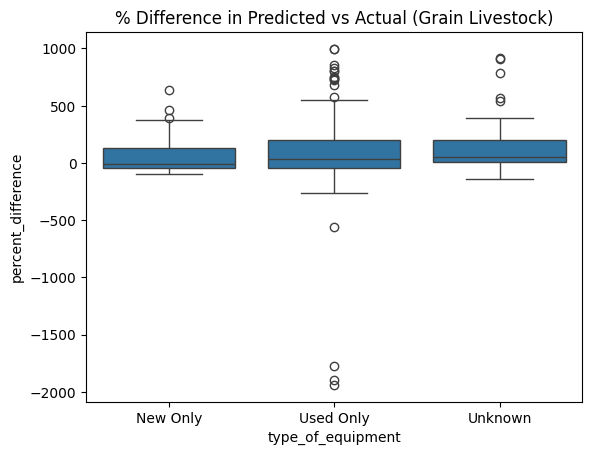

In [611]:
sns.boxplot(
    x="type_of_equipment",
    y="percent_difference",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Grain Livestock")
        & (combined_pd_df["percent_difference"] < 1000)
    ],
)
plt.title("% Difference in Predicted vs Actual (Grain Livestock)")

In [612]:
np.percentile(combined_pd_df.loc[(combined_pd_df["customer_segment"] == "Grain Livestock")]["percent_difference"], 99)

18346.925383753754

Text(0.5, 1.0, '% Difference in Predicted vs Actual (Grain Livestock)')

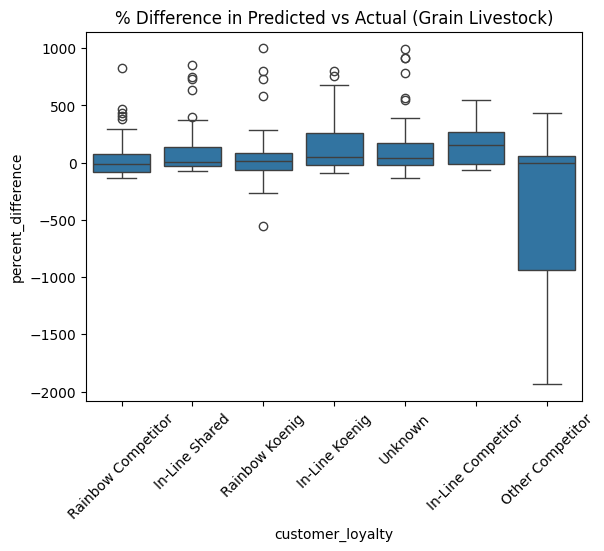

In [613]:
sns.boxplot(
    x="customer_loyalty",
    y="percent_difference",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Grain Livestock")
        & (combined_pd_df["percent_difference"] < 1000)
    ],
)
plt.xticks(rotation=45)
plt.title("% Difference in Predicted vs Actual (Grain Livestock)")

Text(0, 0.5, 'Difference in CLV')

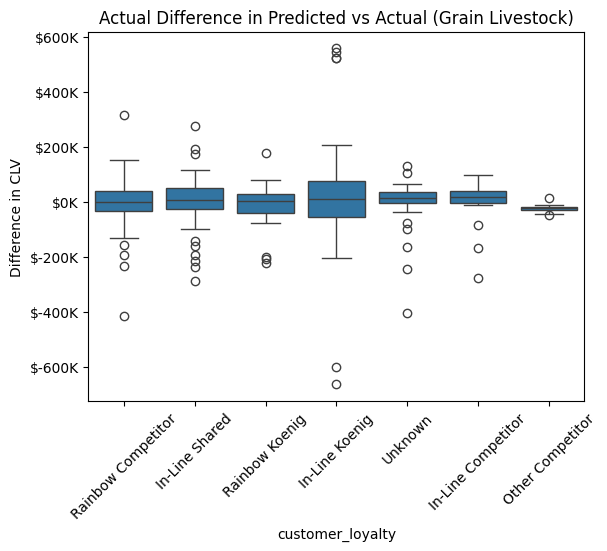

In [627]:
ax = sns.boxplot(
    x="customer_loyalty",
    y="diff",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Grain Livestock")
        & (combined_pd_df["percent_difference"] < 1000)
    ],
)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x / 1000:,.0f}K"))
plt.xticks(rotation=45)
plt.title("Actual Difference in Predicted vs Actual (Grain Livestock)")
plt.ylabel("Difference in CLV")

Text(0, 0.5, 'Difference in CLV')

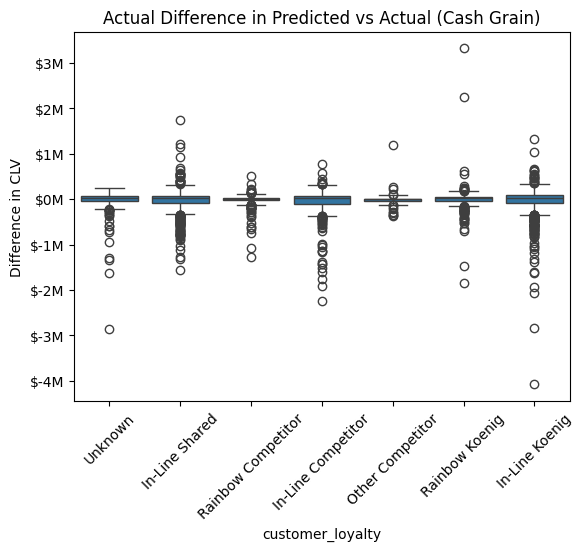

In [629]:
ax = sns.boxplot(
    x="customer_loyalty",
    y="diff",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Cash Grain")
        & (combined_pd_df["percent_difference"] < 1000)
    ],
)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x / 1000000:,.0f}M"))
plt.xticks(rotation=45)
plt.title("Actual Difference in Predicted vs Actual (Cash Grain)")
plt.ylabel("Difference in CLV")

In [575]:
combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"] == "0015f000005XzPuAAK"
].sort_values("latest_year")

,sales_history_account_id,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,latest_year,next_three_years_total_sales,predicted_next_three_years_total_sales,percent_difference
2165,0015f000005XzPuAAK,0,0,0,3500,3500,Grain Livestock,Used Only,In-Line Shared,B - Key Account,MOWER FR,MOWER FR,2018,19,25571.6875,134487.828947
3258,0015f000005XzPuAAK,19,0,0,0,19,Grain Livestock,Used Only,In-Line Shared,B - Key Account,PRIMARY TILLAGE,PRIMARY TILLAGE,2018,194,68013.8125,34958.666237
6749,0015f000005XzPuAAK,19,0,0,0,19,Grain Livestock,Used Only,In-Line Shared,B - Key Account,PRIMARY TILLAGE,PRIMARY TILLAGE,2018,194,68013.8125,34958.666237
11647,0015f000005XzPuAAK,19,0,0,0,19,Grain Livestock,Used Only,In-Line Shared,B - Key Account,PRIMARY TILLAGE,PRIMARY TILLAGE,2018,489,68013.8125,13808.755112


### 4 Year CLV Models

Don't have data pre-2016 and 2024 isn't complete so this is the maximum number of years we can use.

In [630]:
data_4_year_2019_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2019, 2018, 2017, 2016]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_year").max().alias("latest_year"),
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_4_year_2019_next_4_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2020, 2021, 2022, 2023]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_four_years_total_sales"),
    )
)
data_4_year_2019_df = data_4_year_2019_previous_df.join(
    data_4_year_2019_next_4_year_df, on="sales_history_account_id", how="inner"
)
data_4_year_2019_df.head()

sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales
str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,i64
"""0015f000005XN5bAAG""",2019,4539,900,0,0,5439,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""SKID & TRACK LOADERS""","""SKID & TRACK LOADERS""",636
"""0015f000005XCd6AAG""",2019,6251,768,0,0,52370,"""Contractor""","""Unknown""","""Unknown""","""C - Turf Relationship Account""","""COMPACT TRACTOR""","""COMPACT TRACTOR""",18462
"""0015f000005XemRAAS""",2019,3966,63,0,0,4084,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""SNOW BLOWERS""","""SNOW BLOWERS""",8240
"""0015f000005Xp7cAAC""",2019,34405,14869,0,251200,302178,"""Ag Service Provider""","""Used Only""","""Unknown""","""C - Relationship Account""","""SPRAYERS""","""SPRAYERS""",192
"""0015f000005XzZQAA0""",2019,92702,39187,0,6550,142481,"""Grain Hogs""","""Used Only""","""Rainbow Koenig""","""C - Relationship Account""","""OTHER LANDSCAPE EQ""","""OTHER LANDSCAPE EQ""",219195


In [631]:
data_4_year_2020_previous_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2020, 2017, 2016, 2015]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_year").max().alias("latest_year"),
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_4_year_2020_next_4_year_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2021, 2022, 2023, 2024]))
    .sort("sales_history_year", descending=False)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_total_sales").sum().alias("next_four_years_total_sales"),
    )
)
data_4_year_2020_df = data_4_year_2020_previous_df.join(
    data_4_year_2020_next_4_year_df, on="sales_history_account_id", how="inner"
)
data_4_year_2020_df.head()

sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales
str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,i64
"""0015f000005Xff6AAC""",2020,141,387,0,0,598,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""RIDERS LAWN TRACTORS""","""RIDERS LAWN TRACTORS""",1172
"""0015f000005X2vIAAS""",2020,4293,427,0,1940,6660,"""Governmental""","""Unknown""","""Unknown""","""C - Turf Relationship Account""","""UTILITY VEHICLES""","""COMPACT TRACTOR""",33691
"""0015f000005XUAVAA4""",2020,25156,9298,0,372902,407356,"""Cash Grain""","""Used Only""","""In-Line Shared""","""C - Relationship Account""","""CORN HEADS""","""COMBINES""",13521
"""0015f000005XkWCAA0""",2020,1805,19,0,0,1824,"""Cash Grain""","""Used Only""","""In-Line Koenig""","""C - Relationship Account""","""ROW CROP TRACTOR""","""ROW CROP TRACTOR""",301490
"""0015f000005XyJKAA0""",2020,20830,19240,0,0,63776,"""Cash Grain""","""New Only""","""In-Line Koenig""","""B - Key Account""","""GRAIN HAULING""","""ROW CROP TRACTOR""",550345


In [660]:
combined_df = pl.concat([data_4_year_2019_df, data_4_year_2020_df])
unique_accounts = combined_df["sales_history_account_id"].unique()

unique_accounts_train, unique_accounts_test = np.split(
    unique_accounts, [int(0.8 * len(unique_accounts))]
)

In [661]:
combined_pd_df = combined_df.to_pandas()
combined_pd_df = combined_pd_df.loc[
    (combined_pd_df["customer_business_class"] != "A - Turf Strategic Account")
    & (combined_pd_df["customer_segment"] != "Specialty Crop")
    & (combined_pd_df["customer_loyalty"] != "CNV")
    & (combined_pd_df["most_common_group"] != "SPRAYERATT")
    & (combined_pd_df["most_common_group"] != "SEEDINGATT")
    & (combined_pd_df["next_four_years_total_sales"] > 0)
]
cont_vars = [
    "parts_sales",
    "service_sales",
    "rental_sales",
    "sales_history_wholegood_sales",
]
cat_vars = [
    "customer_segment",
    "type_of_equipment",
    "customer_loyalty",
    "most_common_group",
    "largest_sales_group",
]
X = combined_pd_df[cont_vars + cat_vars]
X_train = combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"].isin(unique_accounts_train)
][cont_vars + cat_vars]
y_train = combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"].isin(unique_accounts_train)
]["next_four_years_total_sales"]

X_test = combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"].isin(unique_accounts_test)
][cont_vars + cat_vars]
y_test = combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"].isin(unique_accounts_test)
]["next_four_years_total_sales"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cont_vars),  # Scale continuous variables
        (
            "cat",
            OneHotEncoder(drop="first"),
            cat_vars,
        ),  # One-hot encode categorical variables
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb.XGBRegressor(objective="reg:squarederror", random_state=69)),
    ]
)

In [662]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the standard deviation of the MSE
mse_std = np.std((y_test - y_pred) ** 2)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Standard Deviation of MSE: {mse_std:.4f}")

Mean Squared Error (MSE): 254059696292.0944
Standard Deviation of MSE: 1964855752588.3779


In [663]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb.XGBRegressor(objective="reg:absoluteerror", random_state=69)),
    ]
)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X)
combined_pd_df = combined_pd_df.copy()
combined_pd_df["predicted_next_four_years_total_sales"] = preds
combined_pd_df["percent_difference"] = (
    (
        combined_pd_df["predicted_next_four_years_total_sales"]
        - combined_pd_df["next_four_years_total_sales"]
    )
    / combined_pd_df["next_four_years_total_sales"]
    * 100
)
combined_pd_df["diff"] = (
    combined_pd_df["predicted_next_four_years_total_sales"]
    - combined_pd_df["next_four_years_total_sales"]
)
combined_pd_df.head()

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference,diff
0,0015f000005XN5bAAG,2019,4539,900,0,0,5439,Unknown,Unknown,Unknown,Unknown,SKID & TRACK LOADERS,SKID & TRACK LOADERS,636,9713.619141,1427.298607,9077.619141
1,0015f000005XCd6AAG,2019,6251,768,0,0,52370,Contractor,Unknown,Unknown,C - Turf Relationship Account,COMPACT TRACTOR,COMPACT TRACTOR,18462,12383.822266,-32.922640,-6078.177734
2,0015f000005XemRAAS,2019,3966,63,0,0,4084,Unknown,Unknown,Unknown,Unknown,SNOW BLOWERS,SNOW BLOWERS,8240,13067.152344,58.581946,4827.152344
3,0015f000005Xp7cAAC,2019,34405,14869,0,251200,302178,Ag Service Provider,Used Only,Unknown,C - Relationship Account,SPRAYERS,SPRAYERS,192,400835.312500,208668.391927,400643.312500
4,0015f000005XzZQAA0,2019,92702,39187,0,6550,142481,Grain Hogs,Used Only,Rainbow Koenig,C - Relationship Account,OTHER LANDSCAPE EQ,OTHER LANDSCAPE EQ,219195,264081.531250,20.477899,44886.531250


<Axes: xlabel='type_of_equipment', ylabel='percent_difference'>

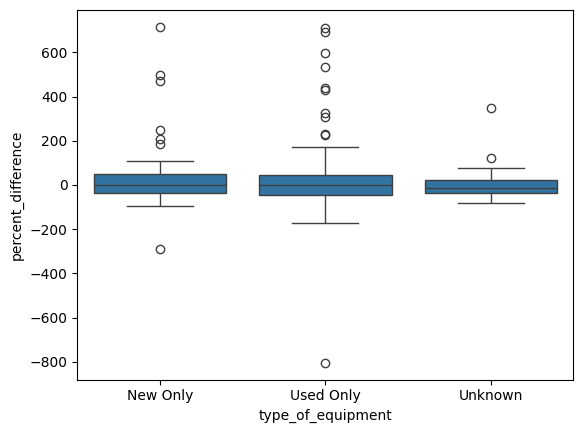

In [649]:
sns.boxplot(
    x="type_of_equipment",
    y="percent_difference",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Grain Livestock")
        & (combined_pd_df["percent_difference"].abs() < 1000)
    ],
)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'In-Line Shared'),
  Text(1, 0, 'In-Line Competitor'),
  Text(2, 0, 'Unknown'),
  Text(3, 0, 'Rainbow Koenig'),
  Text(4, 0, 'In-Line Koenig'),
  Text(5, 0, 'Rainbow Competitor'),
  Text(6, 0, 'Other Competitor')])

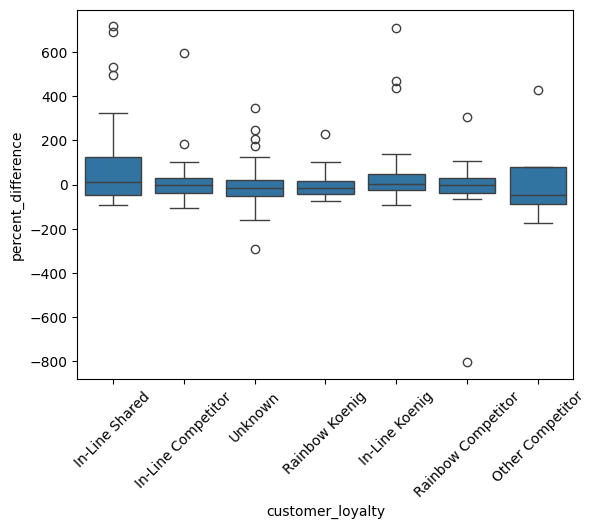

In [648]:
sns.boxplot(
    x="customer_loyalty",
    y="percent_difference",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Grain Livestock")
        & (combined_pd_df["percent_difference"].abs() < 1000)
    ],
)
plt.xticks(rotation=45)

Text(0, 0.5, 'Difference in CLV')

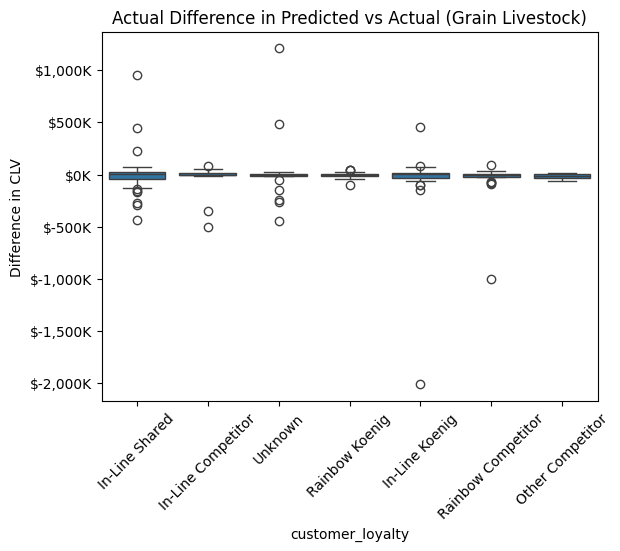

In [653]:
ax = sns.boxplot(
    x="customer_loyalty",
    y="diff",
    data=combined_pd_df.loc[
        (combined_pd_df["customer_segment"] == "Grain Livestock")
        & (combined_pd_df["percent_difference"].abs() < 1000)
    ],
)
plt.xticks(rotation=45)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"${x / 1000:,.0f}K"))
plt.title("Actual Difference in Predicted vs Actual (Grain Livestock)")
plt.ylabel("Difference in CLV")

In [654]:
combined_pd_df.sort_values("diff", ascending=False).head()

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference,diff
702,0015f000005XYdnAAG,2019,42495,21282,0,700,66090,Unknown,Unknown,Unknown,C - Relationship Account,LAWN GARDEN TRACTOR,LAWN GARDEN TRACTOR,235384,3541537.750,1404.578795,3306153.750
2125,0015f000005XAEzAAO,2019,62752,16690,0,1734159,1826517,Cash Grain,New Only,In-Line Koenig,B - Key Account,ROW CROP TRACTOR,ROW CROP TRACTOR,97478,2900473.250,2875.515757,2802995.250
2570,0015f000005XejWAAS,2019,101131,32816,0,10140,151773,Unknown,Unknown,Unknown,C - Relationship Account,MOWER FR,MOWER FR,141329,1943399.125,1275.088711,1802070.125
1858,0015f000005XVvZAAW,2019,112797,34902,0,2074899,2240494,Cash Grain,New Only,In-Line Competitor,A - Strategic Account,COMBINES,COMBINES,3614,1742976.500,48128.458771,1739362.500
3813,0015f000005XVvZAAW,2020,95631,34090,0,1914034,2049251,Cash Grain,New Only,In-Line Competitor,A - Strategic Account,COMBINES,COMBINES,2414,1714452.000,70921.209611,1712038.000


In [664]:
combined_pd_df.sort_values("diff", ascending=True).head()

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference,diff
5226,0015f000005X30dAAC,2020,5130,7056,0,195395,208266,Cash Grain,Unknown,In-Line Competitor,A - Strategic Account,DRAPER PLATFORMS,DRAPER PLATFORMS,19425778,1.005788e+05,-99.482241,-1.932520e+07
2610,0015f000005X30dAAC,2019,1596,0,0,0,1596,Cash Grain,Unknown,In-Line Competitor,A - Strategic Account,SNOW BLOWERS,SNOW BLOWERS,14034693,1.095667e+04,-99.921932,-1.402374e+07
3849,0015f000005X31MAAS,2020,87060,27398,0,1649136,1768328,Cash Grain,New Only,Rainbow Koenig,A - Strategic Account,COMBINES,COMBINES,9570403,2.346137e+06,-75.485492,-7.224266e+06
3097,0015f000005XvMiAAK,2019,22725,13721,0,2984223,3020744,Cash Grain,New Only,In-Line Koenig,B - Key Account,ROW CROP TRACTOR,ROW CROP TRACTOR,6786069,9.630355e+05,-85.808640,-5.823034e+06
6279,0015f000005X325AAC,2020,8373,16720,0,0,30353,Cash Grain,New Only,In-Line Competitor,A - Strategic Account,ROW CROP TRACTOR,ROW CROP TRACTOR,5936094,2.246700e+05,-96.215188,-5.711424e+06


In [475]:
combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"] == "0015f000005XyabAAC"
].sort_values("latest_year")

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference
677,0015f000005XyabAAC,2019,11023,7090,0,32565,51128,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,60481,81263.117188,34.361398
5434,0015f000005XyabAAC,2020,16967,9050,0,32565,59479,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,70314,115555.671875,64.342338


In [476]:
combined_pd_df.loc[
    (combined_pd_df["customer_segment"] == "Grain Livestock")
    & (combined_pd_df["percent_difference"] > 1000)
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference
1070,0015f000005XO4EAAW,2019,4234,2293,0,0,10427,Grain Livestock,Used Only,In-Line Shared,C - Relationship Account,ZERO,ZERO,920,20302.500000,2106.793478
1242,0015f000005XyLMAA0,2019,21778,11920,0,1760,35628,Grain Livestock,Used Only,In-Line Shared,C - Relationship Account,COMBINES,COMBINES,2674,32338.718750,1109.376169
2108,0015f000005XDNuAAO,2019,20989,417,0,0,21406,Grain Livestock,Used Only,Unknown,C - Relationship Account,GRAIN HAULING,GRAIN HAULING,83,36110.433594,43406.546498
3867,0015f000005XyjdAAC,2020,29111,17097,0,123669,170677,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,HEAD CARRIERS,COMBINES,1285,67206.640625,5130.088765
4095,0015f000005XsHHAA0,2020,20999,505,0,7350,28854,Grain Livestock,Used Only,Unknown,C - Relationship Account,ROW CROP TRACTOR,AUGER PLATFORMS,10651,123004.960938,1054.867721
5882,0015f000005XDNuAAO,2020,17303,417,0,0,17720,Grain Livestock,Used Only,Unknown,C - Relationship Account,CORN HEADS,CORN HEADS,51,1559.198975,2957.252891
5901,0015f000005XuwzAAC,2020,4739,3242,0,114436,122417,Grain Livestock,New Only,In-Line Koenig,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,711,28242.400391,3872.208212
6062,0015f000005XPYKAA4,2020,0,0,0,536079,536164,Grain Livestock,New Only,Unknown,B - Key Account,DRAPER PLATFORMS,ROW CROP TRACTOR,857,15396.793945,1696.592059


In [477]:
combined_pd_df.loc[
    (combined_pd_df["customer_segment"] == "Grain Livestock")
    & (combined_pd_df["customer_loyalty"] == "In-Line Koenig")
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference
175,0015f000005XLbPAAW,2019,16319,4118,0,159037,196708,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,49778,4.225869e+04,-15.105686
248,0015f000005Xx6mAAC,2019,106174,75943,0,60081,243218,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,PLANTERS,COMBINES,172647,9.063843e+05,424.992796
401,0015f000005XykCAAS,2019,33941,31587,0,8828,74896,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,33269,1.108816e+05,233.287957
606,0015f000005Xvj3AAC,2019,2501,740,0,4088,16686,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,UTILITY VEHICLES,UTILITY VEHICLES,5814,2.750146e+03,-52.697863
921,0015f000005XwjYAAS,2019,2556,101,0,17700,20424,Grain Livestock,New Only,In-Line Koenig,C - Relationship Account,AUGER PLATFORMS,AUGER PLATFORMS,189343,5.313971e+04,-71.934684
1097,0015f000005XmmFAAS,2019,7212,0,0,6400,13612,Grain Livestock,Used Only,In-Line Koenig,Investigate,HEAD CARRIERS,ROW CROP TRACTOR,10009,2.751704e+04,174.922979
1213,0015f000005Xne1AAC,2019,21746,7026,0,211349,240169,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,4505,3.185261e+04,607.050153
1570,0015f000005XuHdAAK,2019,50593,34218,0,581115,667784,Grain Livestock,New Only,In-Line Koenig,B - Key Account,ZERO,COMBINES,97261,7.285091e+05,649.024917
1661,0015f000005Xhz0AAC,2019,42237,2325,0,163400,209354,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,18541,5.627038e+04,203.491628
1665,0015f000005XuQtAAK,2019,26990,16438,0,184050,255245,Grain Livestock,New Only,In-Line Koenig,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,274347,3.103670e+05,13.129369


In [478]:
combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"] == "0015f000005Xne1AAC"
].sort_values("latest_year")

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,next_four_years_total_sales,predicted_next_four_years_total_sales,percent_difference
1213,0015f000005Xne1AAC,2019,21746,7026,0,211349,240169,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,4505,31852.609375,607.050153
5561,0015f000005Xne1AAC,2020,14992,3423,0,0,18415,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,4298,24704.056641,474.780285


Predict the next four years

In [655]:
data_4_year_2024_df = (
    data_df.filter(pl.col("sales_history_year").is_in([2024, 2023, 2022, 2021]))
    .sort("sales_history_year", descending=True)
    .group_by("sales_history_account_id")
    .agg(
        pl.col("sales_history_year").max().alias("latest_year"),
        pl.col("sales_history_parts_sales").sum().alias("parts_sales"),
        pl.col("sales_history_service_sales").sum().alias("service_sales"),
        pl.col("sales_history_rental_sales").sum().alias("rental_sales"),
        pl.col("sales_history_wholegood_sales")
        .sum()
        .alias("sales_history_wholegood_sales"),
        pl.col("sales_history_total_sales").sum().alias("total_sales"),
        pl.col("customer_segment").first().alias("customer_segment"),
        pl.col("type_of_equipment").first().alias("type_of_equipment"),
        pl.col("customer_loyalty").first().alias("customer_loyalty"),
        pl.col("customer_business_class").first().alias("customer_business_class"),
        pl.col("most_common_group").first().alias("most_common_group"),
        pl.col("largest_sales_group").first().alias("largest_sales_group"),
    )
)
data_4_year_2024_df.head()

sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group
str,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str
"""0015f000005XwxbAAC""",2023,325,0,0,0,325,"""Cash Grain""","""Unknown""","""Rainbow Competitor""","""C - Relationship Account""","""ROW CROP TRACTOR""","""ROW CROP TRACTOR"""
"""0015f000005X4YaAAK""",2024,113,505,0,0,718,"""Unknown""","""Unknown""","""Unknown""","""Unknown""","""COMPACT TRACTOR""","""COMPACT TRACTOR"""
"""0015f000005X3SuAAK""",2023,328,0,0,0,328,"""Cash Grain""","""Used Only""","""Rainbow Competitor""","""C - Relationship Account""","""COMBINES""","""COMBINES"""
"""0015f000005XJGdAAO""",2022,542,121,0,0,932,"""Cash Grain""","""Unknown""","""Unknown""","""C - Relationship Account""","""UTILITY TRACTOR""","""UTILITY TRACTOR"""
"""0015f000005XCn4AAG""",2024,7573,2394,0,0,10284,"""Cash Grain""","""Used Only""","""Rainbow Koenig""","""C - Relationship Account""","""COMMERCIAL ZERO & FM""","""COMMERCIAL ZERO & FM"""


In [656]:
combined_pd_df = data_4_year_2024_df.to_pandas()
combined_pd_df = combined_pd_df.loc[
    (combined_pd_df["customer_business_class"] != "A - Turf Strategic Account")
    & (combined_pd_df["customer_segment"] != "Specialty Crop")
    & (combined_pd_df["customer_loyalty"] != "CNV")
    & (combined_pd_df["most_common_group"] != "SPRAYERATT")
    & (combined_pd_df["most_common_group"] != "SEEDINGATT")
]
cont_vars = [
    "parts_sales",
    "service_sales",
    "rental_sales",
    "sales_history_wholegood_sales",
]
cat_vars = [
    "customer_segment",
    "type_of_equipment",
    "customer_loyalty",
    "most_common_group",
    "largest_sales_group",
]
X = combined_pd_df[cont_vars + cat_vars]

preds = pipeline.predict(X)
combined_pd_df = combined_pd_df.copy()
combined_pd_df["predicted_next_four_years_total_sales"] = preds
combined_pd_df.head()

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,predicted_next_four_years_total_sales
0,0015f000005XwxbAAC,2023,325,0,0,0,325,Cash Grain,Unknown,Rainbow Competitor,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,216.151108
1,0015f000005X4YaAAK,2024,113,505,0,0,718,Unknown,Unknown,Unknown,Unknown,COMPACT TRACTOR,COMPACT TRACTOR,2401.465332
2,0015f000005X3SuAAK,2023,328,0,0,0,328,Cash Grain,Used Only,Rainbow Competitor,C - Relationship Account,COMBINES,COMBINES,3838.451904
3,0015f000005XJGdAAO,2022,542,121,0,0,932,Cash Grain,Unknown,Unknown,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,5466.338867
4,0015f000005XCn4AAG,2024,7573,2394,0,0,10284,Cash Grain,Used Only,Rainbow Koenig,C - Relationship Account,COMMERCIAL ZERO & FM,COMMERCIAL ZERO & FM,15715.986328


In [658]:
combined_pd_df.loc[
    combined_pd_df["sales_history_account_id"] == "0015f000005XVvZAAW"
].sort_values("latest_year")

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,predicted_next_four_years_total_sales
588,0015f000005XVvZAAW,2023,14,0,0,0,2414,Cash Grain,New Only,In-Line Competitor,A - Strategic Account,COMBINES,COMBINES,11853.222656


In [488]:
combined_pd_df.loc[
    (combined_pd_df["customer_segment"] == "Grain Livestock")
    & (combined_pd_df["customer_loyalty"] == "In-Line Koenig")
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,predicted_next_four_years_total_sales
161,0015f000005Xvj3AAC,2024,4522,587,0,0,5109,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,UTILITY VEHICLES,UTILITY VEHICLES,4.055316e+04
693,0015f000005XuHdAAK,2024,42181,36048,0,571628,659172,Grain Livestock,New Only,In-Line Koenig,B - Key Account,COMBINES,COMBINES,6.148410e+05
782,0015f000005X31iAAC,2024,33877,12543,0,0,48800,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,4.928010e+04
860,0015f000005X8ZKAA0,2024,41583,20506,0,79000,144402,Grain Livestock,New Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,2.192216e+05
1074,0015f000005XmmFAAS,2024,16001,868,0,0,16978,Grain Livestock,Used Only,In-Line Koenig,Investigate,HEAD CARRIERS,ROW CROP TRACTOR,5.361502e+04
1079,0015f000005Xx6mAAC,2024,75462,55458,0,6485,140483,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,5.815832e+05
1096,0015f000005Xne1AAC,2024,4290,0,0,0,4298,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,COMBINES,COMBINES,1.570243e+04
1484,0015f000005XumWAAS,2024,1982,2807,0,133950,138936,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,PLANTERS,PLANTERS,4.306422e+04
1861,0015f000005XxiEAAS,2024,25757,14672,0,49123,89848,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,UTILITY VEHICLES,UTILITY VEHICLES,4.664015e+04
1870,0015f000005Xhz0AAC,2024,22891,883,0,0,23920,Grain Livestock,Used Only,In-Line Koenig,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,3.036243e+04


In [490]:
combined_pd_df.loc[
    (combined_pd_df["customer_segment"] == "Grain Livestock")
    & (combined_pd_df["customer_loyalty"] == "In-Line Competitor")
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,predicted_next_four_years_total_sales
86,0015f000005XwLBAA0,2024,44978,53337,0,0,105011,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,CORN HEADS,CORN HEADS,92717.140625
312,0015f000005XyabAAC,2024,40792,25557,0,0,70314,Grain Livestock,New Only,In-Line Competitor,C - Relationship Account,UTILITY TRACTOR,UTILITY TRACTOR,156661.390625
1295,0015f000005XuotAAC,2024,45190,10605,0,0,58843,Grain Livestock,Used Only,In-Line Competitor,C - Relationship Account,COMBINES,COMBINES,18503.335938
1430,0015f000005Xx1VAAS,2024,62916,20704,0,674543,760998,Grain Livestock,Used Only,In-Line Competitor,B - Key Account,SPRAYERS,SPRAYERS,886170.000000
3396,0015f000005XuFEAA0,2024,3054,1250,0,4949,9258,Grain Livestock,Used Only,In-Line Competitor,C - Relationship Account,RIDERS LAWN TRACTORS,RIDERS LAWN TRACTORS,20822.048828
3484,0015f000005X8VjAAK,2024,18846,2429,0,0,21987,Grain Livestock,Used Only,In-Line Competitor,D - Transaction Account,ROW CROP TRACTOR,ROW CROP TRACTOR,37815.464844


In [491]:
combined_pd_df.loc[
    (combined_pd_df["customer_segment"] == "Grain Livestock")
    & (combined_pd_df["customer_loyalty"] == "Rainbow Competitor")
]

,sales_history_account_id,latest_year,parts_sales,service_sales,rental_sales,sales_history_wholegood_sales,total_sales,customer_segment,type_of_equipment,customer_loyalty,customer_business_class,most_common_group,largest_sales_group,predicted_next_four_years_total_sales
127,0015f000005XuGMAA0,2024,8948,0,0,0,8962,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,COMMERCIAL ZERO & FM,COMMERCIAL ZERO & FM,1.619660e+04
1180,0015f000005X7rwAAC,2024,26948,3882,0,0,31550,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,AUGER PLATFORMS,AUGER PLATFORMS,6.235884e+04
1386,0015f000005XyCHAA0,2022,0,0,0,19000,19000,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,GRAIN HAULING,GRAIN HAULING,-1.639919e+04
1425,0015f000005Xc3YAAS,2022,0,0,0,89900,89900,Grain Livestock,Unknown,Rainbow Competitor,C - Relationship Account,PLANTERS,PLANTERS,1.774468e+05
1472,0015f000005XyjdAAC,2024,1285,0,0,0,1285,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,HEAD CARRIERS,COMBINES,1.493534e+04
1570,0015f000005XwJiAAK,2024,845,139,0,137970,139124,Grain Livestock,New Only,Rainbow Competitor,C - Relationship Account,PLANTERS,PLANTERS,6.220330e+04
1593,0015f000005XRjYAAW,2024,150932,27599,0,867807,1062842,Grain Livestock,New Only,Rainbow Competitor,B - Key Account,COMBINES,COMBINES,2.072205e+06
1967,0015f000005XwDaAAK,2024,40228,5109,0,0,46567,Grain Livestock,Used Only,Rainbow Competitor,C - Relationship Account,ROW CROP TRACTOR,ROW CROP TRACTOR,8.473395e+04
1985,0015f000005XvDOAA0,2023,8527,3289,0,183496,195952,Grain Livestock,New Only,Rainbow Competitor,C - Relationship Account,TRACK TRACTOR,TRACK TRACTOR,2.469878e+05
3307,0015f000005XuGSAA0,2024,39251,1012,0,2300,43488,Grain Livestock,New Only,Rainbow Competitor,B - Key Account,ZERO,ROW CROP TRACTOR,2.031952e+05
